# Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error

%config IPCompleter.greedy=True

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

import pickle

In [11]:

x = pd.read_pickle('../../02_Data/03_Work/x_preselected.pickle')
y = pd.read_pickle('../../02_Data/03_Work/y_preselected.pickle')


## Modeling for a product

In [14]:
x = x.loc[(x.store_id == 'CA_3') & (x.item_id == 'FOODS_3_586')]

In [16]:
y = y[y.index.isin(x.index)]

In [18]:
var_modeling = x.columns.to_list()[3:]

In [20]:
# crossval specific to time series

time_cv = TimeSeriesSplit(3, test_size = 8) # predict at 8 days in future

#### pipe and dict of algorythms, params and values to test

In [59]:
pipe = Pipeline([('algorythm',HistGradientBoostingRegressor())])

grid = [{'algorythm': [HistGradientBoostingRegressor()],
         'algorythm__learning_rate': [0.01,0.025,0.05,0.1],
         'algorythm__max_iter': [50,100,200],
         'algorythm__max_depth': [None, 5,10,20],
         'algorythm__min_samples_leaf': [20, 500],
         'algorythm__l2_regularization': [0,0.25,0.5,0.75,1]
        }]

random_search = RandomizedSearchCV(estimator = pipe,
                                   param_distributions = grid, 
                                   n_iter = 30, 
                                   cv = time_cv, 
                                   scoring = 'neg_mean_absolute_error', 
                                   verbose = 0,
                                   n_jobs = -1)

model = random_search.fit(x[var_modeling],y)

pd.DataFrame(random_search.cv_results_).sort_values(by = 'rank_test_score').head(3)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorythm__min_samples_leaf,param_algorythm__max_iter,param_algorythm__max_depth,param_algorythm__learning_rate,param_algorythm__l2_regularization,param_algorythm,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
13,0.23,0.01,0.00,0.00,20,50,5,0.10,1,HistGradientBoostingRegressor(),"{'algorythm__min_samples_leaf': 20, 'algorythm...",-9.07,-15.03,-14.70,-12.93,2.73,1
1,0.40,0.02,0.00,0.00,20,100,5,0.10,0.50,HistGradientBoostingRegressor(),"{'algorythm__min_samples_leaf': 20, 'algorythm...",-9.46,-14.53,-15.10,-13.03,2.54,2
25,1.06,0.02,0.01,0.00,20,200,5,0.03,0.75,HistGradientBoostingRegressor(),"{'algorythm__min_samples_leaf': 20, 'algorythm...",-8.77,-15.95,-14.36,-13.03,3.08,3


In [60]:
random_search.best_params_

{'algorythm__min_samples_leaf': 20,
 'algorythm__max_iter': 50,
 'algorythm__max_depth': 5,
 'algorythm__learning_rate': 0.1,
 'algorythm__l2_regularization': 1,
 'algorythm': HistGradientBoostingRegressor()}

In [64]:

final_model = model.best_estimator_.fit(x[var_modeling], y)


In [65]:
prediction = final_model.predict(x[var_modeling])

In [67]:

temp = pd.concat([x.date.reset_index(drop=True),y.reset_index(drop=True),pd.Series(prediction,name = 'prediction')],axis = 1).set_index('date')



In [68]:
temp

,sales,prediction
date,,
2013-01-16,46,53.33
2013-01-17,53,52.19
2013-01-18,53,63.13
2013-01-19,79,74.19
2013-01-20,81,78.87
...,...,...
2015-11-26,100,84.44
2015-11-27,92,80.86
2015-11-28,63,80.19


In [69]:
# this is probably overfitted 
# but we just want it to build the process

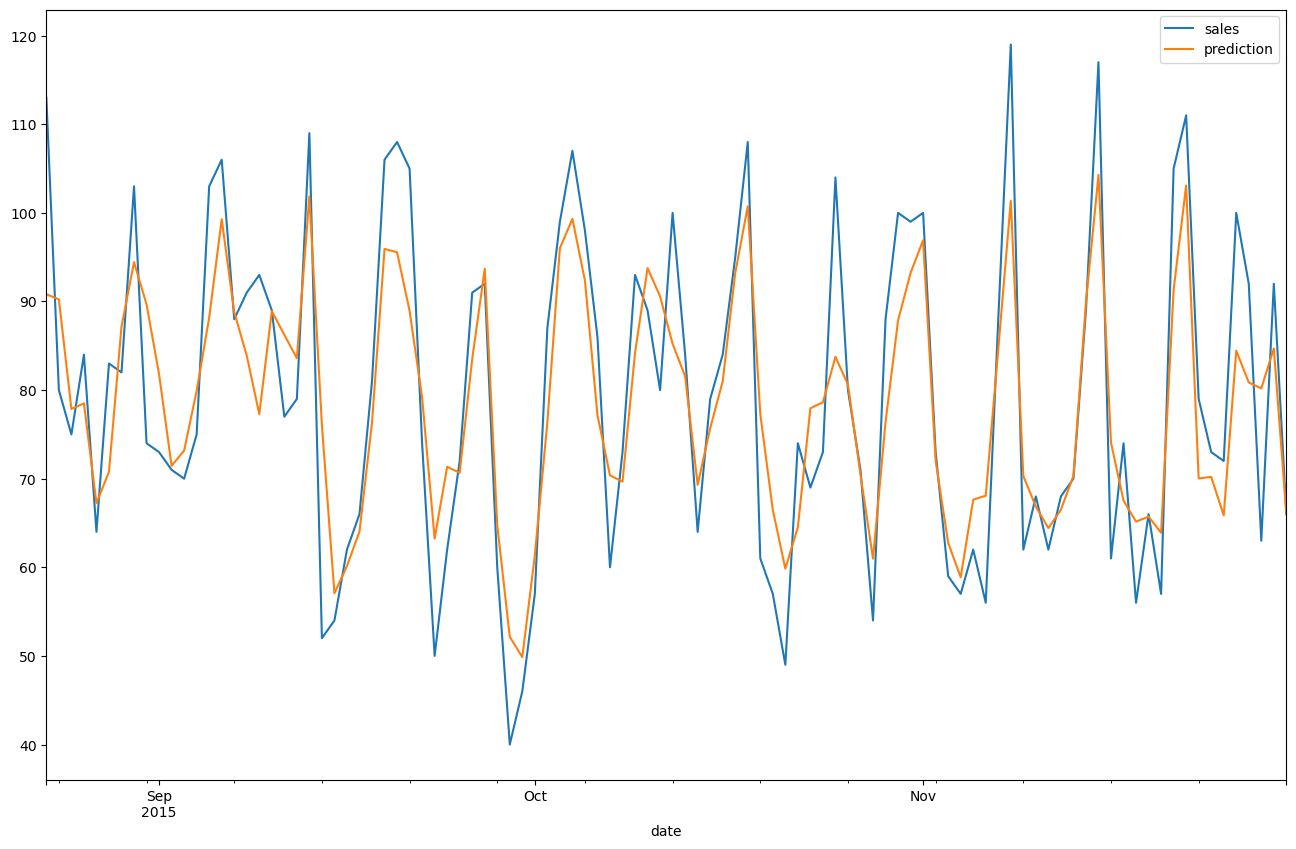

In [70]:
temp.tail(100).plot(figsize = (16,10));

In [71]:
# if this would be very different, 
# probably there would be a problem in the process
